# Predictive Maintenance


Predictive maintenance (PdM) is a data-driven preventive maintanance program. It is a proactive maintenance strategy that uses sensors to monitor the performance and equipment conditions during operation. The PdM methods constantly analyze the data to predict when optimal maintenance schedules. It can reduce maintenance costs and prevent catastrophic equipment failure when used correctly. 

In this notebook, we will apply NeuralForecast to perform a supervised Remaining Useful Life (RUL) estimation on the classic PHM2008 aircraft degradation dataset.

Outline<br>
1. Installing Packages<br>
2. Load PHM2008 aircraft degradation dataset<br>
3. Fit and Predict NeuralForecast<br>
4. Evaluate Predictions

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing Packages

In [ ]:
# %%capture
# !pip install git+https://github.com/Nixtla/neuralforecast.git

In [ ]:
# %%capture
# !pip install git+https://github.com/Nixtla/datasetsforecast.git@predictive_maintenance

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

from neuralforecast.models import NBEATSx, MLP
from neuralforecast import NeuralForecast
#from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss, MQLoss
from neuralforecast.losses.pytorch import HuberLoss, MAE

from datasetsforecast.phm2008 import PHM2008

## 2. Load PHM2008 aircraft degradation dataset

Here we will load the Prognosis and Health Management 2008 challenge dataset. This dataset used the Commercial Modular Aero-Propulsion System Simulation to recreate the degradation process of turbofan engines for different aircraft with varying wear and manufacturing starting under normal conditions. The training dataset consists of complete run-to-failure simulations, while the test dataset comprises sequences before failure.

![](https://github.com/Nixtla/neuralforecast/blob/main/nbs/imgs_losses/turbofan_engine.png?raw=1)

In [ ]:
Y_train_df, Y_test_df = PHM2008.load(directory='./data', group='FD001', clip_rul=False)
Y_train_df

,unique_id,ds,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,y
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


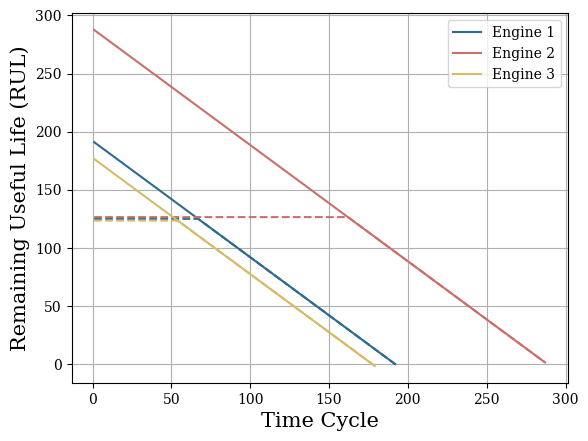

In [ ]:
plot_df1 = Y_train_df[Y_train_df['unique_id']==1]
plot_df2 = Y_train_df[Y_train_df['unique_id']==2]
plot_df3 = Y_train_df[Y_train_df['unique_id']==3]

plt.plot(plot_df1.ds, np.minimum(plot_df1.y, 125), color='#2D6B8F', linestyle='--')
plt.plot(plot_df1.ds, plot_df1.y, color='#2D6B8F', label='Engine 1')

plt.plot(plot_df2.ds, np.minimum(plot_df2.y, 125)+1.5, color='#CA6F6A', linestyle='--')
plt.plot(plot_df2.ds, plot_df2.y+1.5, color='#CA6F6A', label='Engine 2')

plt.plot(plot_df3.ds, np.minimum(plot_df3.y, 125)-1.5, color='#D5BC67', linestyle='--')
plt.plot(plot_df3.ds, plot_df3.y-1.5, color='#D5BC67', label='Engine 3')

plt.ylabel('Remaining Useful Life (RUL)', fontsize=15)
plt.xlabel('Time Cycle', fontsize=15)
plt.legend()
plt.grid()

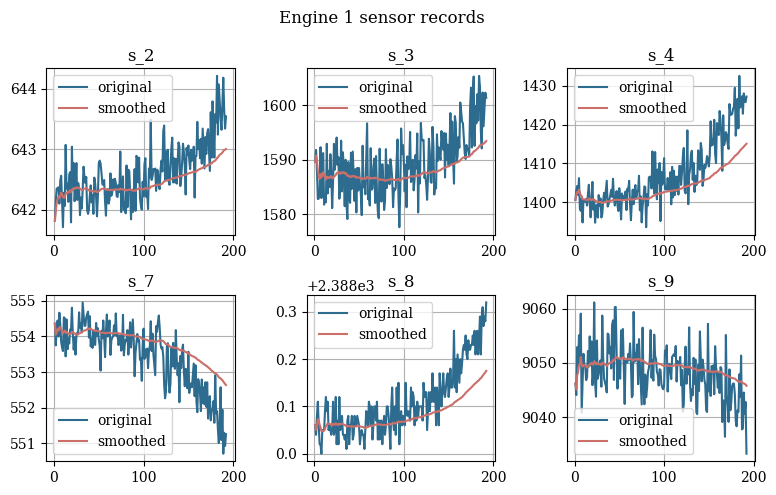

In [ ]:
def smooth(s, b = 0.98):
    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)
    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i
    sm = v[1:] / bc[1:]
    return sm

unique_id = 1
plot_df = Y_train_df[Y_train_df.unique_id == unique_id].copy()

fig, axes = plt.subplots(2,3, figsize = (8,5))
fig.tight_layout()

j = -1
#, 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
for feature in ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9']:
    if ('s' in feature) and ('smoothed' not in feature):
        j += 1
        axes[j // 3, j % 3].plot(plot_df.ds, plot_df[feature], 
                                 c = '#2D6B8F', label = 'original')
        axes[j // 3, j % 3].plot(plot_df.ds, smooth(plot_df[feature].values), 
                                 c = '#CA6F6A', label = 'smoothed')
        #axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
        axes[j // 3, j % 3].set_title(feature)
        axes[j // 3, j % 3].grid()
        axes[j // 3, j % 3].legend()
        
plt.suptitle(f'Engine {unique_id} sensor records')
plt.tight_layout()

## 3. Fit and Predict NeuralForecast

NeuralForecast methods are capable of addressing regression problems involving various variables. The regression problem involves predicting the target variable $y_{t+h}$ based on its lags $y_{:t}$, temporal exogenous features $x^{(h)}_{:t}$, exogenous features available at the time of prediction $x^{(f)}_{:t+h}$, and static features $x^{(s)}$. 

The task of estimating the remaining useful life (RUL) simplifies the problem to a single horizon prediction $h=1$, where the objective is to predict $y_{t+1}$ based on the exogenous features $x^{(f)}_{:t+1}$ and static features $x^{(s)}$. In the RUL estimation task, the exogenous features typically correspond to sensor monitoring information, while the target variable represents the RUL itself.

$$P(y_{t+1}\;|\;x^{(f)}_{:t+1},x^{(s)})$$

In [ ]:
Y_train_df, Y_test_df = PHM2008.load(directory='./data', group='FD001', clip_rul=True)

In [ ]:
%%capture
futr_exog_list =['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

model = MLP(h=1, input_size=24,
                loss=HuberLoss(),
                scaler_type='robust',
                #dropout_prob_theta=0.5,
                futr_exog_list=futr_exog_list,
                max_steps=200)
nf = NeuralForecast(models=[model], freq='M')

nf.fit(df=Y_train_df)
Y_hat_df = nf.predict(futr_df=Y_test_df).reset_index() # By default last window?

Global seed set to 1


In [ ]:
%%capture
filter_test_df = Y_test_df.groupby('unique_id').tail(31).reset_index()
Y_hat_df2 = nf.cross_validation(df=filter_test_df, n_windows=30, fit_models=False)

Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 21.81it/s]


## 4. Evaluate Predictions

In the original PHM2008 dataset the true RUL values for the test set are only provided for the last time cycle of each enginge.
We will filter the predictions to only evaluate the last time cycle.

$$RMSE(\mathbf{y}_{T},\hat{\mathbf{y}}_{T}) = \sqrt{\frac{1}{|\mathcal{D}_{test}|} \sum_{i} (y_{i,T}-\hat{y}_{i,T})^{2}}$$

$$R2(\mathbf{y}_{T},\hat{\mathbf{y}}_{T}) = 1- \frac{\sum_{i} (y_{i,T}-\hat{y}_{i,T})^{2}}{\sum_{i} (y_{i,T}-\bar{y}_{i,T})^{2}}$$

In [ ]:
from sklearn.metrics import r2_score
from neuralforecast.losses.numpy import rmse

y_last = Y_test_df[['unique_id', 'y']].groupby('unique_id').last().reset_index()
y_hat_last = Y_hat_df[['unique_id', 'MLP']].groupby('unique_id').last().reset_index()
y_last = y_last['y']
y_hat_last = y_hat_last['MLP']

rmse_eval = rmse(y=y_last, y_hat=y_hat_last)
r2_eval = r2_score(y_true=y_last, y_pred=y_hat_last)

print('RUL Prognosis Evaluation')
print(f'RMSE:\t {rmse_eval:.3f}')
print(f'R2:\t {r2_eval:.3f}')

RUL Prognosis Evaluation
RMSE:	 0.840
R2:	 1.000


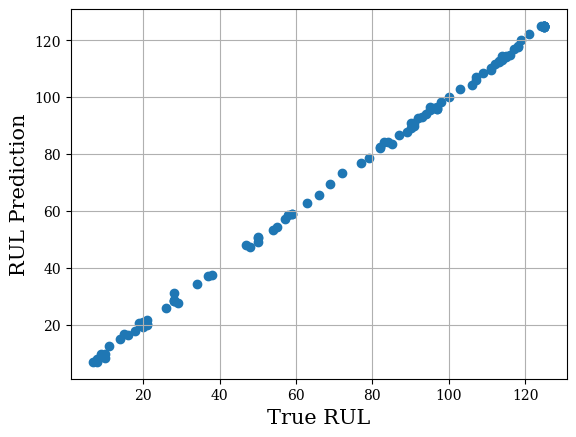

In [ ]:
plt.scatter(y_last, y_hat_last)
plt.xlabel('True RUL', fontsize=15)
plt.ylabel('RUL Prediction', fontsize=15)
plt.grid()

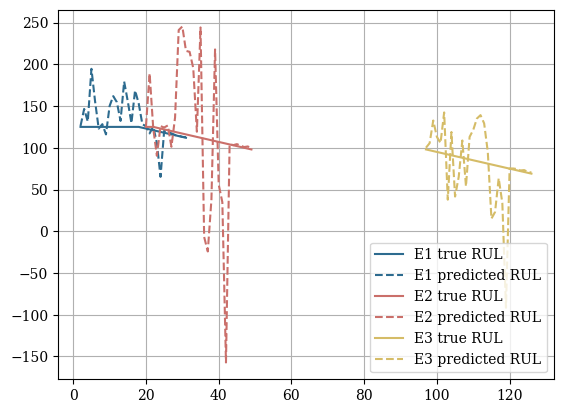

In [ ]:
plot_df1 = Y_hat_df2[Y_hat_df2['unique_id']==1]
plot_df2 = Y_hat_df2[Y_hat_df2['unique_id']==2]
plot_df3 = Y_hat_df2[Y_hat_df2['unique_id']==3]

plt.plot(plot_df1.ds, plot_df1['y'], c='#2D6B8F', label='E1 true RUL')
plt.plot(plot_df1.ds, plot_df1['MLP']+1, c='#2D6B8F', linestyle='--', label='E1 predicted RUL')

plt.plot(plot_df2.ds, plot_df2['y'], c='#CA6F6A', label='E2 true RUL')
plt.plot(plot_df2.ds, plot_df2['MLP']+1, c='#CA6F6A', linestyle='--', label='E2 predicted RUL')

plt.plot(plot_df3.ds, plot_df3['y'], c='#D5BC67', label='E3 true RUL')
plt.plot(plot_df3.ds, plot_df3['MLP']+1, c='#D5BC67', linestyle='--', label='E3 predicted RUL')

plt.legend()
plt.grid()

## References

- [R. Keith Mobley (2002). "An Introduction to Predictive Maintenance"](https://www.irantpm.ir/wp-content/uploads/2008/02/an-introduction-to-predictive-maintenance.pdf)<br>
- [Saxena, A., Goebel, K., Simon, D.,&Eklund, N. (2008). "Damage propagation modeling for aircraft engine run-to-failure simulation". International conference on prognostics and health management.](https://ntrs.nasa.gov/api/citations/20090029214/downloads/20090029214.pdf)